# Estimation of Navier-Stokes equation
## Done by: Andreea-Ioana Florea

In [50]:
print("Hello, world!!!")

Hello, world!!!


In [51]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

In [52]:
# Physical parameters
rho = 1  # Density
mu = 1   # Viscosity
u_in = 1
D = 1
L = 2

# Define geometry: A rectangle
#geom = dde.geometry.Rectangle(xmin=[-L / 2, -D / 2], xmax=[L / 2, D / 2])
# Main channel
channel = dde.geometry.Rectangle(xmin=[-L / 2, -D / 2], xmax=[L / 2, D / 2])

# Obstacle (Cylinder)
center = [0, 0]
radius = 0.1
cylinder = dde.geometry.Disk(center, radius)

# Combined geometry
geom = channel - cylinder

# 1. Define the Heart Shape coordinates
t = np.linspace(0, 2 * np.pi, 100)
# Parametric heart equations scaled down to size 0.1
heart_x = 0.1 * (16 * np.sin(t)**3) / 16
heart_y = 0.1 * (13 * np.cos(t) - 5 * np.cos(2*t) - 2 * np.cos(3*t) - np.cos(4*t)) / 16

# Shift the heart to the LEFT of the center (x = -0.5)
heart_points = np.vstack([heart_x - 0.5, heart_y]).T
heart_shape = dde.geometry.Polygon(heart_points)

# 2. Define the Cylinder and Channel
channel = dde.geometry.Rectangle(xmin=[-L / 2, -D / 2], xmax=[L / 2, D / 2])
cylinder = dde.geometry.Disk([0, 0], 0.1)

geom_space = channel - cylinder - heart_shape
# Define time domain: [t_start, t_end]
geom_time = dde.geometry.TimeDomain(0, 5)
# Combine space and time
geom = dde.geometry.GeometryXTime(geom_space, geom_time)

C:\Users\andre\.conda\envs\challenge_Navier_Stokes_ResNet\lib\site-packages\deepxde\geometry\geometry_2d.py:814: RuntimeWarning: invalid value encountered in divide
  self.normal = self.normal / np.linalg.norm(self.normal, axis=1).reshape(-1, 1)


In [53]:
# Define boundary conditions
def boundary_wall(X, on_boundary):
    on_wall = np.logical_and(
        np.logical_or(
            np.isclose(X[1], -D / 2, rtol=1e-05, atol=1e-08),
            np.isclose(X[1], D / 2, rtol=1e-05, atol=1e-08),
        ),
        on_boundary,
    )
    return on_wall

def boundary_inlet(X, on_boundary):
    on_inlet = np.logical_and(
        np.isclose(X[0], -L / 2, rtol=1e-05, atol=1e-08), on_boundary
    )
    return on_inlet

def boundary_outlet(X, on_boundary):
    on_outlet = np.logical_and(
        np.isclose(X[0], L / 2, rtol=1e-05, atol=1e-08), on_boundary
    )
    return on_outlet

def boundary_cylinder(X, on_boundary):
    # Check if the point is on the boundary and NOT on the outer channel walls
    return on_boundary and not (
        np.isclose(X[0], -L/2) or np.isclose(X[0], L/2) or
        np.isclose(X[1], -D/2) or np.isclose(X[1], D/2)
    )

def boundary_obstacles(X, on_boundary):
    # Logic: It's an obstacle if it's on a boundary but NOT the external box edges
    on_outer_wall = np.logical_or(
        np.logical_or(np.isclose(X[0], -L/2), np.isclose(X[0], L/2)),
        np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2))
    )
    return on_boundary and not on_outer_wall

# No-slip for all internal objects
bc_obs_u = dde.DirichletBC(geom, lambda X: 0.0, boundary_obstacles, component=0)
bc_obs_v = dde.DirichletBC(geom, lambda X: 0.0, boundary_obstacles, component=1)

bc_cylinder_u = dde.DirichletBC(geom, lambda X: 0.0, boundary_cylinder, component=0)
bc_cylinder_v = dde.DirichletBC(geom, lambda X: 0.0, boundary_cylinder, component=1)

bc_wall_u = dde.DirichletBC(geom, lambda X: 0.0, boundary_wall, component=0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0.0, boundary_wall, component=1)

bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component=0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0.0, boundary_inlet, component=1)

bc_outlet_p = dde.DirichletBC(geom, lambda X: 0.0, boundary_outlet, component=2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0.0, boundary_outlet, component=1)

In [54]:
# Define PDE system
def pde(X, Y):
    # X now has 3 columns: [x, y, t]
    # Y has 3 columns: [u, v, p]

    # NEW: Time derivatives
    du_t = dde.grad.jacobian(Y, X, i=0, j=2)
    dv_t = dde.grad.jacobian(Y, X, i=1, j=2)

    # Existing Spatial derivatives
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)

    du_xx = dde.grad.hessian(Y, X, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(Y, X, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(Y, X, component=1, i=1, j=1)

    # Momentum equations now include du_t and dv_t
    pde_u = du_t + Y[:, 0:1] * du_x + Y[:, 1:2] * du_y + 1 / rho * dp_x - (mu / rho) * (du_xx + du_yy)
    pde_v = dv_t + Y[:, 0:1] * dv_x + Y[:, 1:2] * dv_y + 1 / rho * dp_y - (mu / rho) * (dv_xx + dv_yy)
    pde_cont = du_x + dv_y

    return [pde_u, pde_v, pde_cont]

In [55]:
# Use TimePDE for time-dependent (transient) simulations
data = dde.data.TimePDE(
    geom,
    pde,
    [
        # --- Spatial Boundaries ---
        bc_wall_u, bc_wall_v,      # Walls (No slip)
        bc_inlet_u, bc_inlet_v,    # Left Inlet (Flow enters here)
        bc_outlet_p, bc_outlet_v,  # Right Outlet (Flow exits here)
        bc_obs_u, bc_obs_v,        # Obstacles (Heart & Cylinder)
        bc_cylinder_u, bc_cylinder_v,

        # --- Initial Conditions (t=0) ---
        ic_u, ic_v                 # State of fluid at start
    ],
    num_domain=5000,    # Points inside the channel
    num_boundary=1000,  # Points on walls/inlet/outlet
    num_initial=1000    # Points at time t=0
)

C:\Users\andre\.conda\envs\challenge_Navier_Stokes_ResNet\lib\site-packages\deepxde\geometry\geometry_2d.py:920: RuntimeWarning: invalid value encountered in divide
  v = (self.vertices[i + 1] - self.vertices[i]) / self.diagonals[i, i + 1]


In [56]:
# Define neural network
net = dde.maps.FNN([3] + [64] * 5 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

In [57]:
# Compile and train
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=500)

Compiling model...
'compile' took 0.002659 s

Training model...

Cause: could not parse the source code of <function <lambda> at 0x0000025FAB172200>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x0000025FAB172200>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @

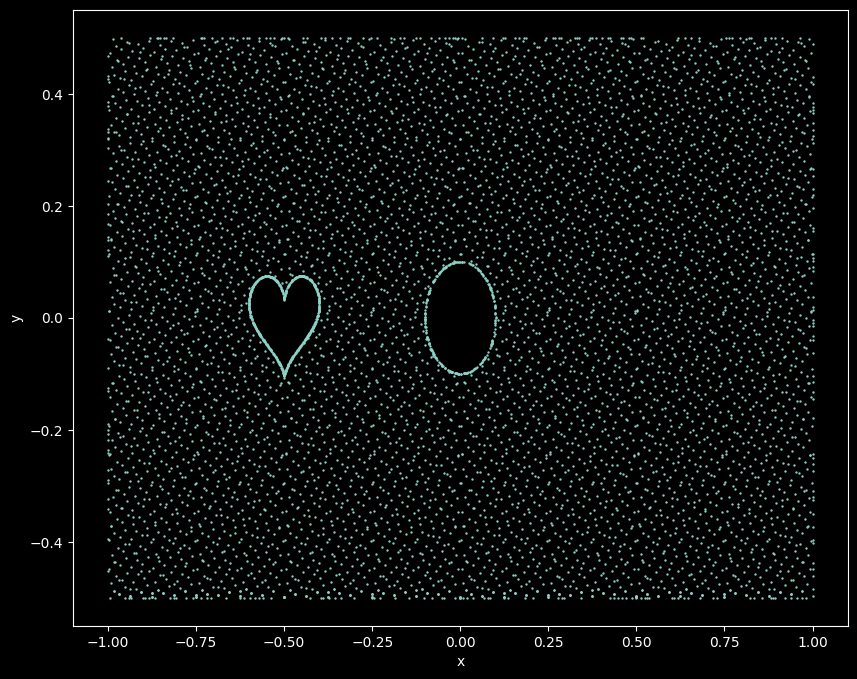

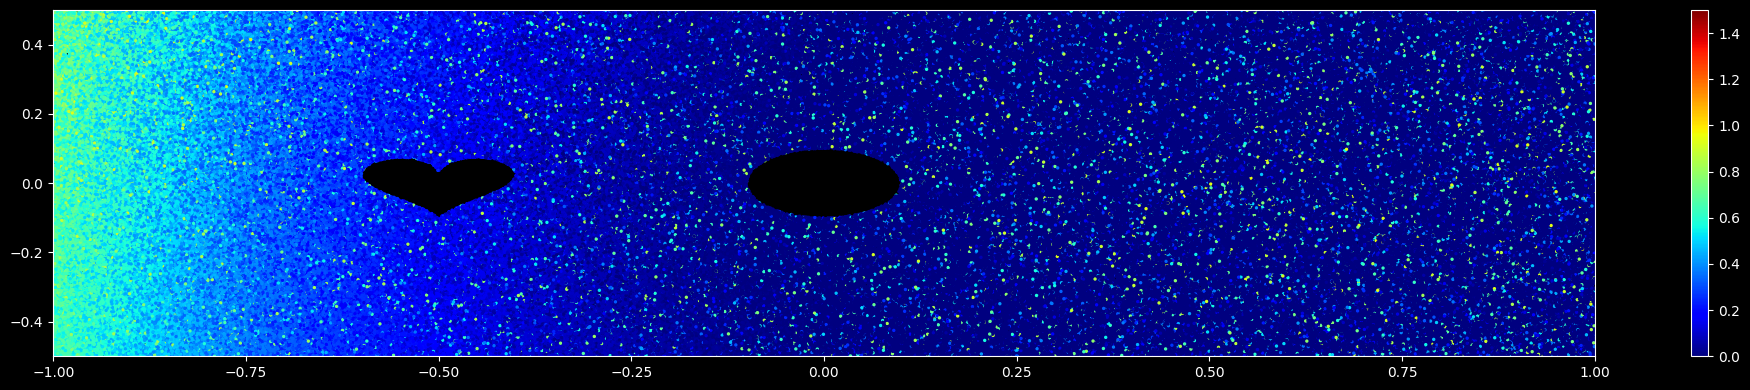

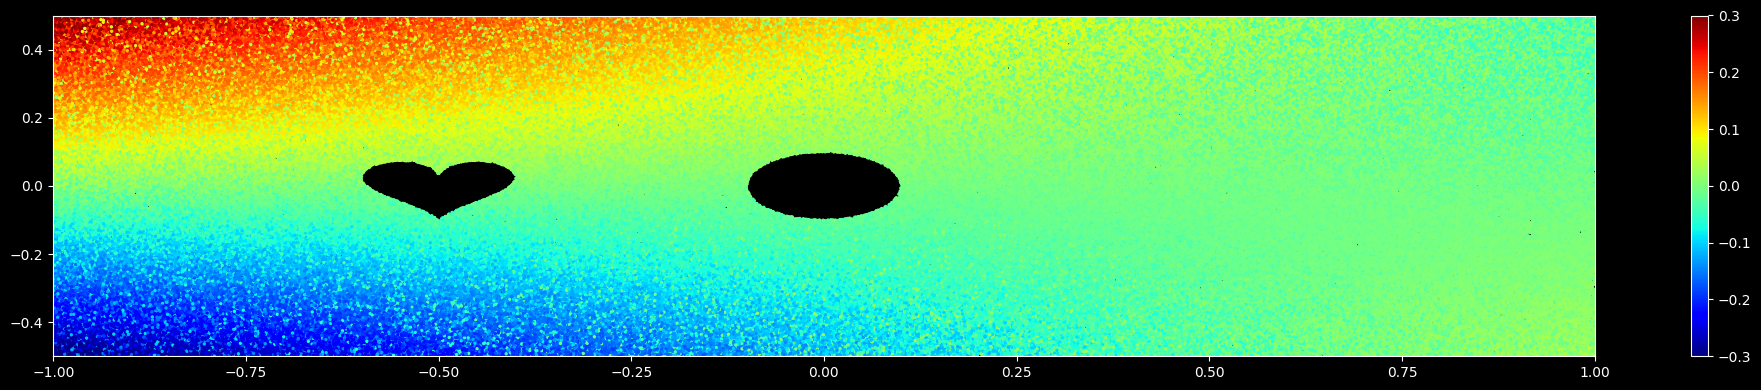

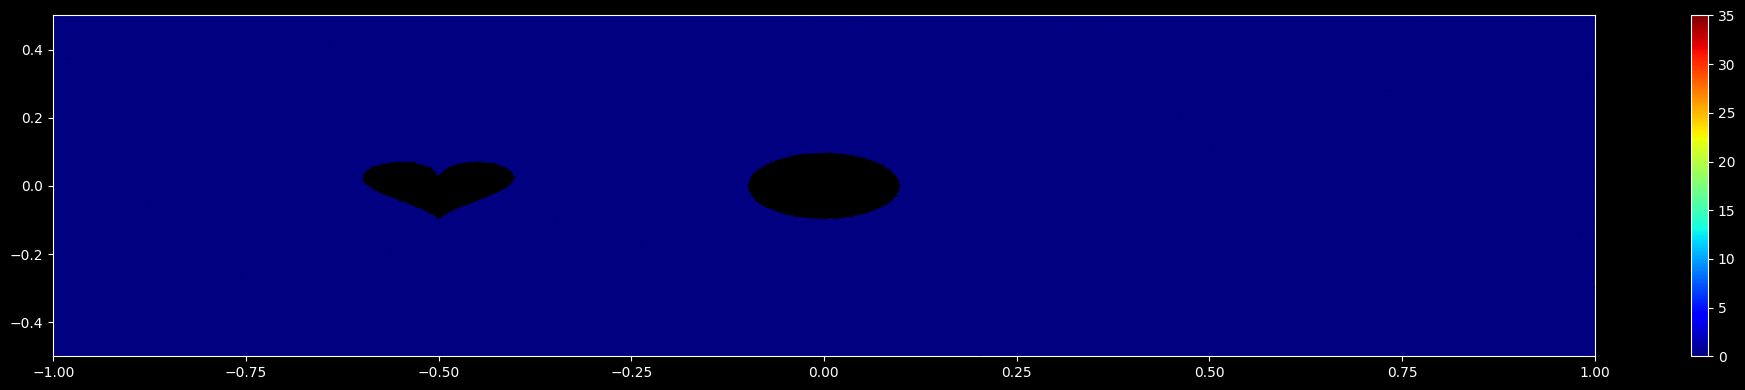

In [58]:
# Visualize training points
plt.figure(figsize=(10, 8))
plt.scatter(data.train_x_all[:, 0], data.train_x_all[:, 1], s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Predict and plot results
samples = geom.random_points(500000)
result = model.predict(samples)

color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize=(20, 4))
    plt.scatter(samples[:, 0], samples[:, 1], c=result[:, idx], cmap="jet", s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0 - L / 2, L - L / 2))
    plt.ylim((0 - D / 2, D - D / 2))
    plt.tight_layout()
    plt.show()

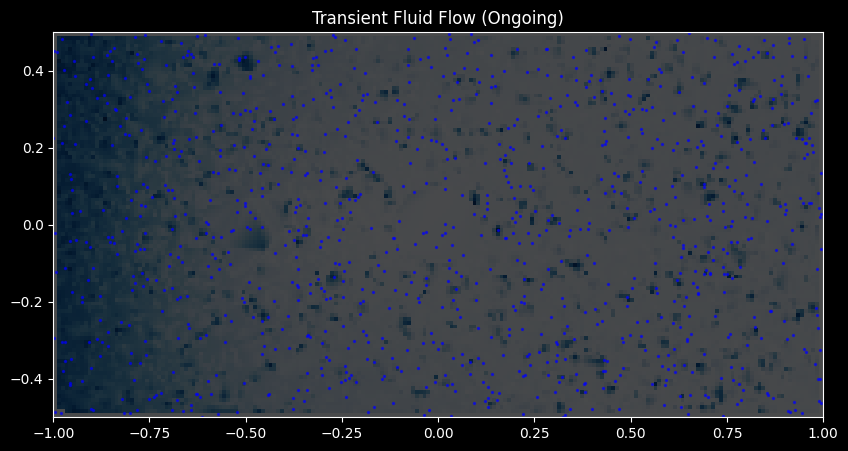

In [59]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from scipy.interpolate import griddata

# 1. Setup the Time and Spatial context
# We use a specific time (e.g., t=0) just to visualize the background speed field
current_t = 0.0
# geom.random_points now returns [x, y, t] - we only need [x, y] for 2D interpolation
samples_3d = geom.random_points(10000)
spatial_coords = samples_3d[:, 0:2]

# Predict initial state
res = model.predict(samples_3d)
u_init = res[:, 0]
v_init = res[:, 1]
speed_init = np.sqrt(u_init**2 + v_init**2)

# 2. Create Background Grid for Speed Visualization
grid_x, grid_y = np.meshgrid(np.linspace(-L/2, L/2, 200), np.linspace(-D/2, D/2, 100))
grid_speed = griddata(spatial_coords, speed_init, (grid_x, grid_y), method='linear', fill_value=0)

# 3. Initialize Particles for "Liquid" effect
num_particles = 1000
# Start particles randomly across the channel
particles_x = np.random.uniform(-L/2, L/2, num_particles)
particles_y = np.random.uniform(-D/2, D/2, num_particles)

fig, ax = plt.subplots(figsize=(10, 5))
# Plot background speed
cont = ax.imshow(grid_speed, extent=(-L/2, L/2, -D/2, D/2), origin='lower', cmap='Blues', alpha=0.3)
# The "Liquid" particles
scat = ax.scatter(particles_x, particles_y, s=2, c='blue', alpha=0.6)

ax.set_xlim(-L/2, L/2)
ax.set_ylim(-D/2, D/2)
ax.set_title("Transient Fluid Flow (Ongoing)")

def update(frame):
    global particles_x, particles_y


Video saved successfully!


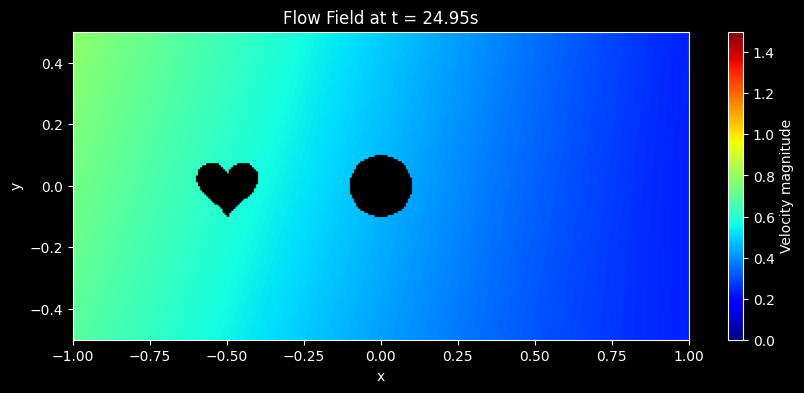

In [61]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import numpy as np
from matplotlib.path import Path

# 1. Create the Regular Grid for Plotting
grid_x, grid_y = np.meshgrid(
    np.linspace(-L/2, L/2, 300),
    np.linspace(-D/2, D/2, 150)
)

# 2. Define the Obstacles (Heart & Cylinder)
# Cylinder mask
mask_cylinder = (grid_x**2 + grid_y**2) < 0.1**2

# Heart mask
# Re-create the path using the points defined at the start of your script
heart_path = Path(heart_points)
points_flat = np.column_stack([grid_x.ravel(), grid_y.ravel()])
mask_heart = heart_path.contains_points(points_flat).reshape(grid_x.shape)

# Combine masks
mask_total = mask_cylinder | mask_heart

# 3. Setup the Figure
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title("Transient Flow with Obstacles")

# Initialize the plot with a placeholder (zeros)
# We use vmin/vmax to keep colors consistent
cax = ax.imshow(np.zeros_like(grid_x),
                extent=(-L/2, L/2, -D/2, D/2),
                origin='lower', cmap='jet', vmin=0, vmax=1.5)
fig.colorbar(cax, ax=ax, label='Velocity magnitude')

# 4. The Animation Update Function
def update(frame):
    # Calculate current time (e.g., advancing 0.05s per frame)
    current_t = frame * 0.05

    # Create input coordinates for the whole grid at this specific time
    # Input structure: [x, y, t]
    t_column = np.full((grid_x.size, 1), current_t)
    X_predict = np.column_stack([grid_x.flatten(), grid_y.flatten(), t_column])

    # Predict velocity
    result = model.predict(X_predict)
    u = result[:, 0].reshape(grid_x.shape)
    v = result[:, 1].reshape(grid_x.shape)
    speed = np.sqrt(u**2 + v**2)

    # Apply the mask (Nan makes it white/transparent)
    speed[mask_total] = np.nan

    # Update the image
    cax.set_data(speed)
    ax.set_title(f"Flow Field at t = {current_t:.2f}s")
    return cax,

# 5. Run and Save
# Increase frames to see the flow evolve longer
ani = FuncAnimation(fig, update, frames=500, interval=50, blit=False)

try:
    writer = FFMpegWriter(fps=20)
    ani.save("flow_field_obstacles_fixed.mp4", writer=writer, dpi=200)
    print("Video saved successfully!")
except Exception as e:
    print(f"Could not save video: {e}")

plt.show()

In [62]:
def update(frame):
    ax.clear()
    # Create a time array for the current frame
    t_step = frame * 0.1
    t_array = np.full((grid_x.ravel().shape[0], 1), t_step)

    # Combine grid points with current time: [x, y, t]
    X_test = np.column_stack([grid_x.ravel(), grid_y.ravel(), t_array])

    # Predict for this specific time
    res = model.predict(X_test)
    u_frame = res[:, 0].reshape(grid_x.shape)
    v_frame = res[:, 1].reshape(grid_x.shape)
    speed_frame = np.sqrt(u_frame**2 + v_frame**2)

    # Apply masks and plot
    speed_frame[mask_total] = np.nan
    cax = ax.imshow(speed_frame, extent=(-L/2, L/2, -D/2, D/2),
                    origin='lower', cmap='jet')

    # Optional: Add streamplot for extra "fluidity"
    # ax.streamplot(grid_x, grid_y, u_frame, v_frame, color='white', alpha=0.3)

    return cax,